#  Taxi Order Prediction

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. I will build a model for such a prediction.

The value of the *RMSE* metric on the test sample should not exceed 48.

I need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.

## Prepairing

Starting the project, I load the necessary libraries and the dataframe for researching.

In [110]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

I translate the information from the first column in datetime format. This column will be considered an index.

In [111]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

## Analysis

According to the condition of the task, the data was ready for analysis, I proceed to the initial assessment.

In [112]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Checking for monotonicity...

In [113]:
df.index.is_monotonic

True

...ended in success.

The data is taken into account with an interval of 10 minutes. I am resampling the main dataframe for 1 hour by summing the number of orders.

In [114]:
df = df.resample('1H').sum()

As well as resampling by months and weeks to refine the analysis.

In [115]:
monthly = df.resample('1M').sum()
weekly = df.resample('1W').sum()

Text(0.5, 1.0, 'Количество заказов по месяцам')

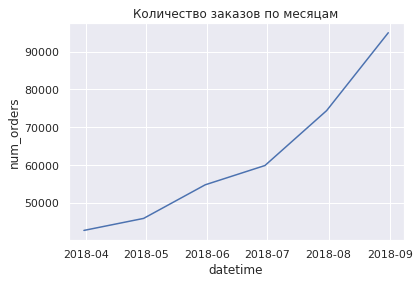

In [116]:
sns.lineplot(x=monthly.index,y=monthly['num_orders']).set_title('Количество заказов по месяцам')

Text(0.5, 1.0, 'Количество заказов по дням')

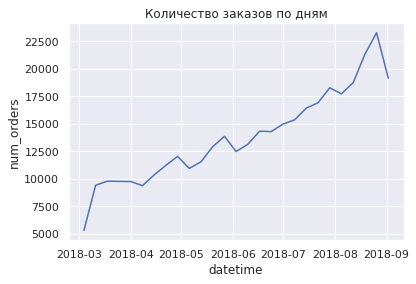

In [117]:
sns.lineplot(x=weekly.index,y=weekly['num_orders']).set_title('Количество заказов по дням')

Evaluation of the moving average and moving standard deviation.

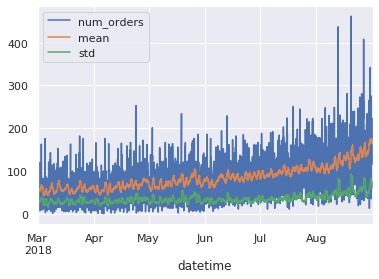

In [118]:
df_gr = df.copy()
df_gr['mean'] = df['num_orders'].rolling(25).mean()
df_gr['std'] = df['num_orders'].rolling(25).std()
df_gr.plot()

I copy the dataframe in order to decompose.

In [119]:
df_copy = df.copy()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

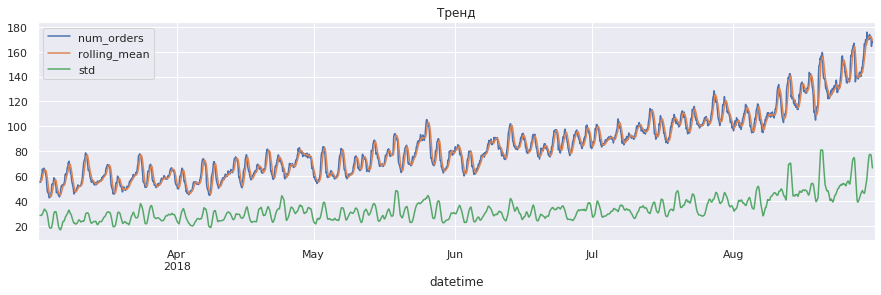

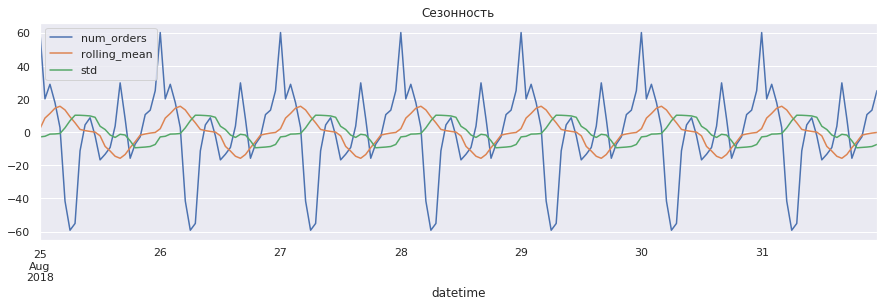

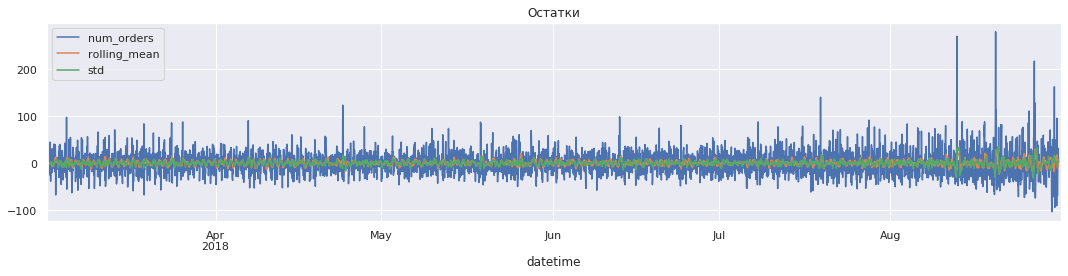

In [120]:
decomposed_df = seasonal_decompose(df_copy)
decomposed_df.trend.plot(title='Тренд', figsize=(15,4))
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,4))
plt.figure(figsize=(15, 4))
decomposed_df.resid.plot(title='Остатки', figsize=(15,4), ax=plt.gca())
plt.tight_layout()

As you can see, the number of orders is constantly growing, seasonality is perfectly traceable - it indicates a change in activity during the day. I'll check it on a one-day view.

Text(0.5, 1.0, 'Сезонность в течении дня')

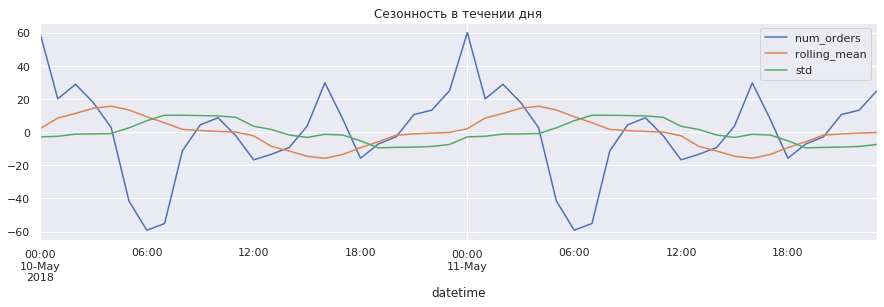

In [121]:
decomposed_df.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня')

Everything is really so. I will check for stationarity of the series using the Dickey-Fuller test.

* The null hypothesis H0 says that the series is not stationary
* The alternative hypothesis H1 says that the series is stationary

In [122]:
test_stat, p_val, _, _, crit_val, _ = sts.adfuller(df.num_orders)
test_stat

-3.068924289027949

In [123]:
p_val

0.02894005140261345

In [124]:
crit_val

{'1%': -3.431842162413052,
 '5%': -2.8621993540813637,
 '10%': -2.567120978470452}

p-value is significantly less than 0.05, statistics are less than critical at 5 and 10 percent significance levels.


<b/> The null hypothesis is rejected. The series is considered to be stationary. </b>

Plotting autocorrelation functions to test data relationships with data from previous periods.

<function matplotlib.pyplot.show(*args, **kw)>

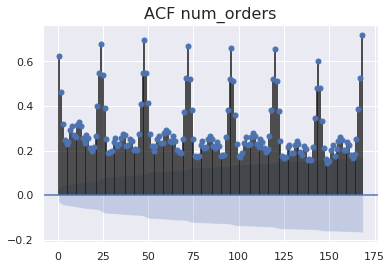

In [125]:
sgt.plot_acf(df.num_orders,  lags = 168, zero = False)
plt.title('ACF num_orders', size = 16)
plt.show

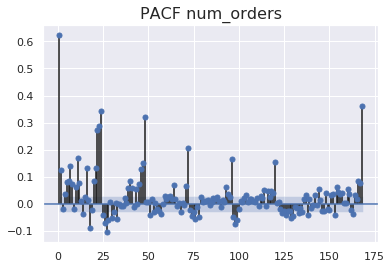

In [126]:
sgt.plot_pacf(df.num_orders, lags = 168, zero = False, method= ('ols'))
plt.title('PACF num_orders', size = 16)
plt.show()

The data is highly correlated with the value for previous periods. I turn to the creation of features.

To do this, I create a function that highlights calendar features and a moving average.

In [127]:
def make_features(data, max_lag, rolling_mean_size):
    
    df['one_day_lag'] = df.num_orders.shift(24)      #value shifted by a day  
    
    data["weekday"] = data.index.weekday             #value of the day of the week
    
    #data['is_weekend'] = data.weekday.isin([5,6])*1  #feature of the day off
    
    data['hour'] = data.index.hour                   #hour value
    

    
    for lag in range(1, max_lag + 1):                #features of shifts
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() #feature of moving average     
    
    return data

In [128]:
df = make_features(df, 6, 24) #maximum number of shifts 6, moving average window size - 24 hours

In [129]:
df

,num_orders,one_day_lag,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,72.0,4,19,207.0,217.0,197.0,116.0,133.0,166.0,164.875000
2018-08-31 20:00:00,154,142.0,4,20,136.0,207.0,217.0,197.0,116.0,133.0,167.541667
2018-08-31 21:00:00,159,198.0,4,21,154.0,136.0,207.0,217.0,197.0,116.0,168.041667


I divide the sample into training and target.

In [130]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

I apply the function and separate the features - I separate the target.

In [131]:
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

I check the location of the time data in the samples so that the data from the future does not fall into the training sample.

In [132]:
display(X.tail(3))
display(X_test.head(3))

,one_day_lag,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-08-13 11:00:00,81.0,0,11,156.0,137.0,91.0,39.0,66.0,83.0,137.250000
2018-08-13 12:00:00,123.0,0,12,144.0,156.0,137.0,91.0,39.0,66.0,139.875000
2018-08-13 13:00:00,120.0,0,13,92.0,144.0,156.0,137.0,91.0,39.0,138.583333


,one_day_lag,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-08-13 14:00:00,104.0,0,14,119.0,92.0,144.0,156.0,137.0,91.0,138.541667
2018-08-13 15:00:00,149.0,0,15,102.0,119.0,92.0,144.0,156.0,137.0,138.458333
2018-08-13 16:00:00,153.0,0,16,175.0,102.0,119.0,92.0,144.0,156.0,139.541667


Checking sample sizes.

In [133]:
print('Размеры обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размеры тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размеры обучающей выборки: 3950 объектов, 10 признаков
Размеры тестовой выборки: 442 объектов, 10 признаков


Standardization of lagging values.

In [134]:
#num_cols = [x for x in df.columns if x.startswith('lag') ]

In [135]:
#scaler = StandardScaler()
#scaler.fit(X[num_cols])
#X[num_cols] = scaler.transform(X[num_cols])
#X_test[num_cols]=scaler.transform(X_test[num_cols])

## Training

Enumeration of models and selection of the best parameters through cross-validation.

In [136]:
models = [RandomForestRegressor(random_state=42),
          LGBMRegressor(random_state=42),
          Ridge(random_state=42),
          Lasso(random_state=42)
         ]

param_grid = [{'n_estimators': [50, 100, 200],
             'max_depth': [5, 10, 15]},
              
              {'max_depth': [2, 4, 8],
               'num_leaves': [2, 4, 8],
               'learning_rate': [0.05, 0.1, 0.5]},
              
              {'alpha': np.logspace(0,3,4)},
              
              {'alpha': np.logspace(0,3,4)}]

cv = TimeSeriesSplit(n_splits=8)
results = []
best_score = 10000
best_model = None
for i, model in enumerate(models):
    grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid[i],
                          cv = cv,
                          scoring = 'neg_mean_squared_error')
    result = grid_search.fit(X, y)
    cv_results = pd.DataFrame(result.cv_results_)[['mean_test_score',
                                                   'std_test_score',
                                                   'mean_fit_time',
                                                   'mean_score_time',
                                                   'rank_test_score']]
    cv_results['Model'] = str(model).split('(')[0]
    cv_results['RMSE'] = np.sqrt(abs(cv_results['mean_test_score']))
    if cv_results['RMSE'].min() < best_score:
        best_score=cv_results['RMSE'].min()
        best_model = result.best_estimator_
    results.append(cv_results)

Comparison of the quality of models.

In [137]:
pd.concat([result for result in results], axis=0).sort_values(by='RMSE', ascending = True).reset_index(drop=True)

,mean_test_score,std_test_score,mean_fit_time,mean_score_time,rank_test_score,Model,RMSE
0,-606.867341,200.187498,0.877773,0.045756,1,LGBMRegressor,24.634678
1,-613.982791,201.039896,0.544202,0.047571,2,LGBMRegressor,24.778676
2,-625.095981,207.575361,1.715419,0.021998,1,RandomForestRegressor,25.001920
3,-628.745465,212.304516,0.858428,0.010750,2,RandomForestRegressor,25.074797
4,-630.023443,229.201093,0.534917,0.075090,3,LGBMRegressor,25.100268
5,-632.112505,215.423234,1.437001,0.019905,3,RandomForestRegressor,25.141848
6,-632.418703,219.273397,0.357751,0.054951,4,LGBMRegressor,25.147936
7,-632.418703,219.273397,0.620264,0.053790,4,LGBMRegressor,25.147936
8,-635.709632,218.314444,0.686585,0.010098,4,RandomForestRegressor,25.213283
9,-635.877204,170.107365,0.427246,0.024013,6,LGBMRegressor,25.216606


Choice of the best model.

In [138]:
best_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=8, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

The best result is shown by the LGBMRegressor model. I conduct testing, calculate RMSE.

## Testing

I test and evaluate the performance of the best model. I start by estimating the RMSE on the test set.

In [139]:
predictions = best_model.predict(X_test)
print("RMSE_test", np.sqrt(mean_squared_error(y_test, predictions)))

RMSE_test 43.8533830148689


## General Conclusion

Thus, the threshold of 48 RMSE units has been passed. The cleaned data is analyzed, new features are created, the model and its hyperparameters are defined, the model is tested.

In [140]:
true_pred = pd.DataFrame({ 
    'y_true' : y_test,
    'y_pred' : best_model.predict(X_test)
    })

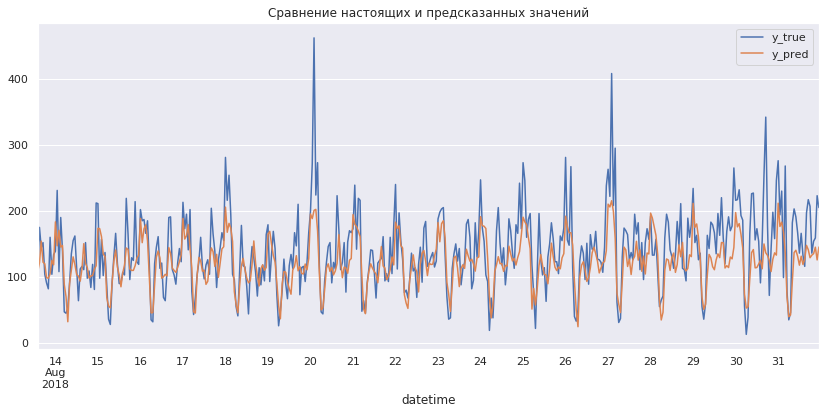

In [141]:
true_pred.plot(figsize=(14,6), title='Сравнение настоящих и предсказанных значений');

In [142]:
from sklearn.model_selection import cross_validate
cv_dict = cross_validate(best_model, X, y, return_train_score=True)
cv_dict

{'fit_time': array([1.36782455, 0.89802313, 0.6064353 ]),
 'score_time': array([0.09900975, 0.01006937, 0.01220059]),
 'test_score': array([0.54243064, 0.56876285, 0.41482401]),
 'train_score': array([0.71688822, 0.76223933, 0.72671221])}

In [143]:
feature_importances = pd.DataFrame({'features' : list(X.columns), 
                                    'feature_importances':  best_model.feature_importances_})\
                                    .sort_values(by='feature_importances', ascending=False)
print('Влияние признаков на результат предсказания')
display(feature_importances)

Влияние признаков на результат предсказания


,features,feature_importances
2,hour,181
0,one_day_lag,93
3,lag_1,69
1,weekday,67
5,lag_3,61
4,lag_2,57
9,rolling_mean,56
6,lag_4,41
8,lag_6,40
7,lag_5,35


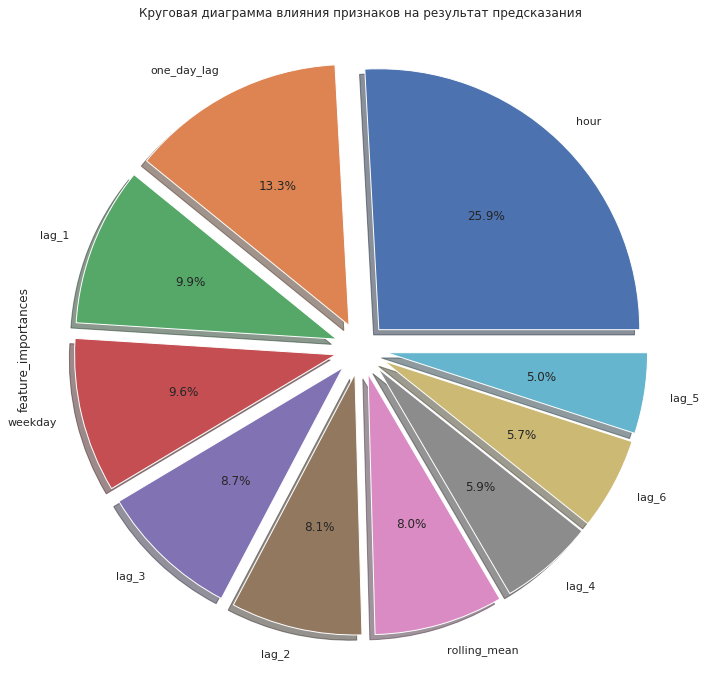

In [144]:
feature_importances.plot.pie(explode=[0.1]*len(X.columns),
                             labels = feature_importances.features,
                             y = 'feature_importances', autopct='%1.1f%%', shadow=True, legend=False, figsize=(12, 12), 
                             title='Круговая диаграмма влияния признаков на результат предсказания');